# ScoreCAM

## Introduction

Visual Explainability Methods  produce a saliency map showing how important each pixel is for their label of classification. These are suitable for image data because they are visual-appealing and can be generally classified into two types:

**a. Backpropagation-based Methods**
These methods distinguish the effect of input features on the final prediction based on
some evaluation of gradient signals passed from output to input during network training. Saliency maps highlight the pixels in order of importance to the DNN prediction, based on derivatives. Several works have followed line, some of these methods
are: Activation Maximization , Deconvolution, Class Activation Mapping
(CAM) and the subsequent methods Grad-CAM and GradCAM++ that
generalize it, Layer-Wise Relevance Propagation (LRP), Deep Learning Important
FeaTures (DeepLIFT), Integrated Gradients. These methods generally have low
quality and noise and lose information in the backpropagation process (vanishing gradient) due to Sigmoid and ReLU activations.

**b. Perturbation-based Methods**
These methods compare the difference in the prediction when the input features are
changed. The most known methods are Occlusion by different types of perturbations 
such as replacing the region with a constant value, adding noise to a region, and blurring
a region; and Smooth Masks.

It is important to note that saliency-based methods have presented many disadvantages.
Saliency maps are based on only one image (Local Methods,.3). Thus, to draw
a conclusion for each class with these methods, the human will have to do it in a one-by-one
process. Also, saliency-based methods are not robust, since they are vulnerable to adversarial attacks as it was presented by Ghorbani[4]. Kindermans and Hooker[5] explored how some saliency methods behaved when the input data was shifted, e.g. change in the input encoding from [0; 1] to [−1; 0], addition of constant squares or a hand drawn cat image in the
background. Their results showed that explanations generated by methods such as Deconvolution, Integrated Gradients are different than the ones produced before these simple
transformations, which means that explanations can be manipulated and these methods are not
reliable.
Since evaluating the quality of an explanation only with visual inspection can be deceiving,
Adebayo et al.[2] proposed Sanity Checks, a new way to evaluate explanations based on the
fact that if the prediction changes, the explanation would also change. For this, they performed
two types of tests: the model parameter randomization test, and the data randomization test.
Model parameters encode what the DNN has learned, in order to debug the DNN and thus,
improve their performance, it is necessary that saliency methods be sensitive to model parameters. 

Figure 1 shows the explanation for an age bone predictor trained on Inception v4 and
after randomizing all the weights in the model. 

Figure 2 shows the performance of explainability methods based on saliency maps after applying a cascading randomization on Inception V3
trained with ImageNet. Notice that even though the weights on the network change (that is, the
prediction changed), the saliency map of some methods remains the same, while Gradient and
GradCAM passed the sanity checks.




![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/sanity-smooth.png?raw=true)

*Figure 2: Explanations B (trained Inception v4) and C (Inception v4 with Random weights) showing no difference. Figure reproduced from Adebayo et al.[2].*

![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/saliency.png?raw=true)

*Figure 3: Saliency results for diverse methods after Cascading Randomization on Inception
V3. They do not accomplish sanity check question: When prediction changes, do explanations
change? Figure reproduced from Adebayo et al.[2].*



Furthermore, saliency methods can obtain deceitful explanations. Fong et al. [3] showed
how different visual methods can get a different explanation without the need of changing the
input as it was discussed before. For example, in Figure 3, in the first row it can be seen in the firt
row the results for some Backpropagation-based Methods and Perturbation-based Methods for
the label “chocolate-sauce”, and how different the heatmaps are, some explanations highlighted
he chocolate pot or the spoon or both. These different explanations generate confusion about
what the network is really basing on for its decision. To prove what method was accurate, they
occluded some regions in the image and compared how the prediction of the DNN changed
(second row in Figure 3), demonstrating that the spoon was indeed what the DNN 3focused on.
This can be because of some bias in the dataset that is most of chocolate sauce images have a
spoon.


![picture](https://github.com/RosePY/deepexplain/blob/ScoreCAM/ScoreCAM/images/falsifiabl.png?raw=true)
*Figure 3: Comparison of Explanations for the label “Chocolate sauce”. The first row shows
results from different visual methods. The second row shows how the prediction accuracy
changes after occluding a part (red box) of the image. This network classified the image as a
chocolate sauce with 0.61 of accuracy. When occluding the chocolate pot, the accuracy for this
label turns to be 0.351. However, if just the handle of the spoon is occluded, the accuracy for
the label ‘chocolate sauce’ drops to 0.015, even though the image still contains ins the chocolate
pot and the part of the spoon with chocolate. Figure reproduced from Fong et al.[3].*


Last year, on CVPR 2020, a combination of perturbation and Class Activation Mapping based methods was presented. Wang et al.[2] proposed a visual explanation method, Score-CAM,  giving a score to each activation map according to how each one will affect the prediction when applied as a mask to the input image. In this notebook we will show some basic experiments with this method.

## ScoreCAM Algorithm



1.   Extract  activation maps at the desired layer
2.   Upsample maps to the original input size in the network
3.   Normalize maps values  in the range of 0-1
4.   Apply the activation map as a mask to the input by multiplying the normalized activation map
5.   Feed masked inputs into CNN model and softmax
6.   Define weight as the score of target class
7.   Get final class discriminative localization map as linear weighted combination of all activation maps




## Simple Experiments

### CNN implementation & training

In this section, a classifier for classes 1 and 8 of MNIST is trained.

In [1]:
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM

import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import optim 
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=lambda x: np.array(x))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=lambda x: np.array(x))


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
from torch.utils.data import DataLoader, Subset
def retrieve_indices(classes,dataset):
  class_indices=[i for i,label in enumerate(dataset.targets) if int(label) in classes] # label itself was a tensor :/
  return class_indices

classes=[1,8]
trainset=Subset(mnist_trainset,retrieve_indices(classes,mnist_trainset))

testset=Subset(mnist_testset,retrieve_indices(classes,mnist_testset))

train_dataloader=DataLoader(trainset,batch_size=50,shuffle=True)

test_dataloader=DataLoader(testset,batch_size=50,shuffle=True)

In [4]:

class mnist_cnn(nn.Module):

  def __init__(self,batch_transform,loss):
    super(mnist_cnn,self).__init__()

    self.conv1=nn.Conv2d(in_channels=1,out_channels=10,kernel_size=4,stride=2)
    self.conv2=nn.Conv2d(in_channels=10,out_channels=20,kernel_size=3,stride=2)
    self.conv3=nn.Conv2d(in_channels=20,out_channels=10,kernel_size=2,stride=2)
    self.dense=nn.Linear(in_features=90,out_features=1)
    self.batch_transform=batch_transform
    self.loss=loss

  def forward(self,x):

    x=self.batch_transform(x) # eg. rescale
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=F.relu(self.conv3(x))
    x=torch.flatten(x,start_dim=1)
    x=torch.sigmoid(self.dense(x))

    return x

In [5]:
def binarize_labels(labels,classes): # classes[0] becomes ~0, classes[1] ~1
 
  return ((labels-classes[0])/(classes[1]-classes[0])).to(torch.float32)


def trainstep(model,optimizer,batch):

  labels=binarize_labels(batch[1],classes)

  optimizer.zero_grad()
  logits=model(batch[0])[:,0]

  loss=model.loss(logits,labels)

  loss.backward()
  optimizer.step()

  return loss.detach()

In [6]:
model=mnist_cnn(batch_transform=lambda x: (x/255.).reshape(-1,1,28,28), loss=nn.BCELoss()) # standard choice to rescale image
print(model)

mnist_cnn(
  (conv1): Conv2d(1, 10, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(20, 10, kernel_size=(2, 2), stride=(2, 2))
  (dense): Linear(in_features=90, out_features=1, bias=True)
  (loss): BCELoss()
)


In [7]:

def accuracy(model,batch):

  n=batch[0].shape[0]

  probabilities=model(batch[0])[:,0]

  correct=0

  for i in range(n):
    if probabilities[i]>0.5 and batch[1][i]>4:
      correct+=1
    elif probabilities[i]<0.5 and batch[1][i]<4:
      correct+=1
  return correct/n

In [8]:
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [9]:

for i in range(10):
  full_loss=0
  full_accuracy=0
  for j,batch in enumerate(train_dataloader):
    loss=trainstep(model,optimizer,batch)
    full_loss=full_loss*j/(j+1)+loss.detach()/(j+1) # compute average in a 'sliding' manner, maybe familiar from RL
    full_accuracy=full_accuracy*j/(j+1)+accuracy(model,batch)/(j+1)
  print('epoch completed')
  print(full_loss)
  print(full_accuracy)

epoch completed
tensor(0.6566)
0.7410594315245479
epoch completed
tensor(0.3635)
0.9271963824289415
epoch completed
tensor(0.1544)
0.9518253968253956
epoch completed
tensor(0.1065)
0.9644186046511628
epoch completed
tensor(0.0864)
0.9702916205241786
epoch completed
tensor(0.0745)
0.9750664451827249
epoch completed
tensor(0.0666)
0.9779235880398669
epoch completed
tensor(0.0610)
0.9790346991509776
epoch completed
tensor(0.0564)
0.9800793650793655
epoch completed
tensor(0.0521)
0.9815873015873005


### Score-CAM

In [10]:
# Code adapted from https://github.com/yiskw713/ScoreCAM
class ScoreCAM(CAM):
    """ Score CAM """

    def __init__(self, model, target_layer, n_batch=32):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """
        self.n_batch = n_batch

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        with torch.no_grad():
            _, _, H, W = x.shape
            device = x.device

            self.model.zero_grad()
            score = self.model(x)
            prob = F.softmax(score, dim=1)

            if idx is None:
                p, idx = torch.max(prob, dim=1)
                idx = idx.item()
                #print("predicted class ids {}\t probability {}".format(idx, p))

            # 1. Getting activation maps
            self.activations = self.values.activations.to('cpu').clone()
            self.activations = F.relu(self.activations)
            # 2. Upsampling
            self.activations = F.interpolate(
                self.activations, (H, W), mode='bilinear')
            _, C, _, _ = self.activations.shape

            # 3. Normalization
            act_min, _ = self.activations.view(1, C, -1).min(dim=2)
            act_min = act_min.view(1, C, 1, 1)
            act_max, _ = self.activations.view(1, C, -1).max(dim=2)
            act_max = act_max.view(1, C, 1, 1)
            denominator = torch.where(
                (act_max - act_min) != 0., act_max - act_min, torch.tensor(1.)
            )

            self.activations = self.activations / denominator

           # 4. generate masked images and 5. calculate class probabilities
            probs = []
            for i in range(0, C, self.n_batch):
                mask = self.activations[:, i:i+self.n_batch].transpose(0, 1)
                mask = mask.to(device)
                masked_x = x * mask
                score = self.model(masked_x)
                probs.append(F.softmax(score, dim=1)[:, idx].to('cpu').data)
            
            # 6. Extracting weight as the score 
            probs = torch.stack(probs)
            weights = probs.view(1, C, 1, 1)

            # 7. Linear weighted combination
            cam = (weights * self.activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

        return cam.data, idx

    def __call__(self, x):
        return self.forward(x)

To test ScoreCAM, last convolutional layer will be chosen.

In [11]:
target_layer = model.conv3
wrapped_model = ScoreCAM(model, target_layer)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


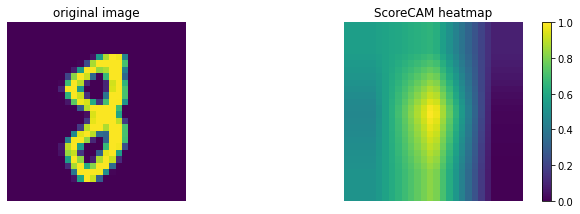

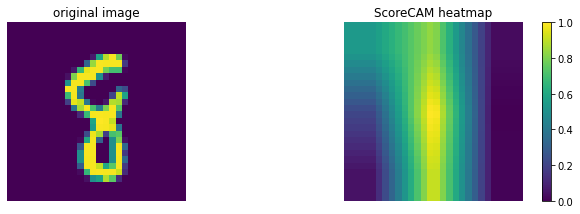

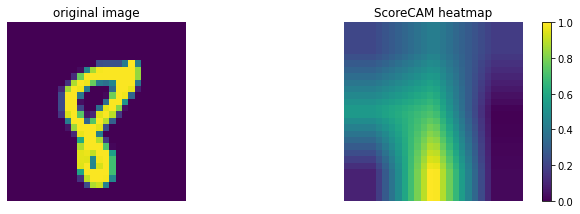

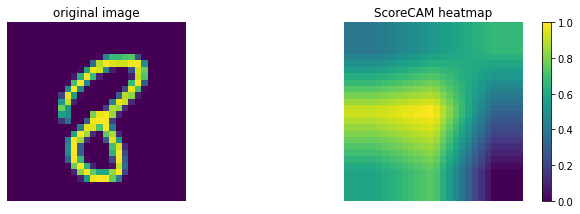

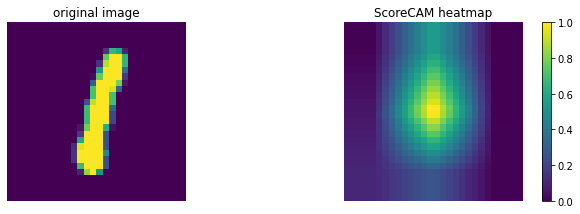

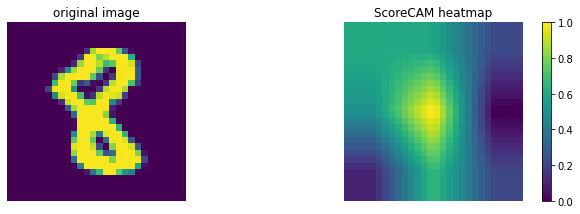

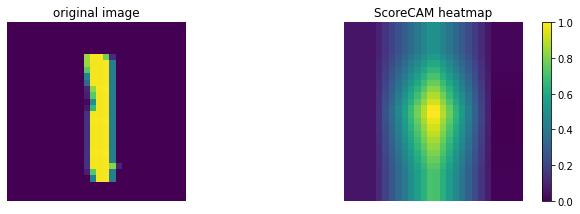

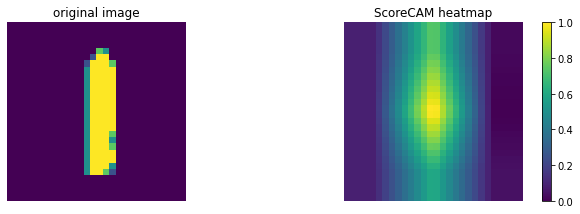

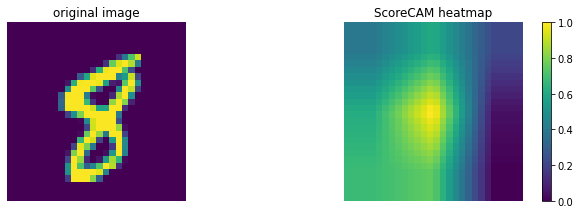

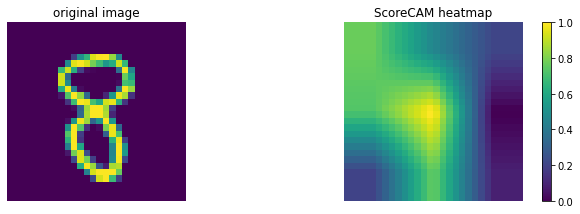

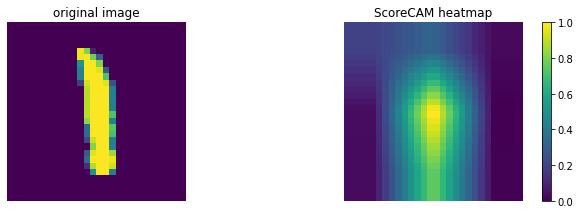

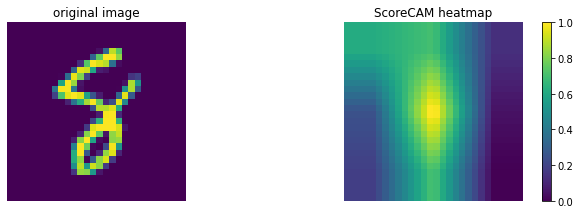

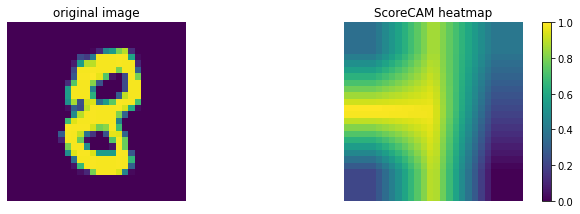

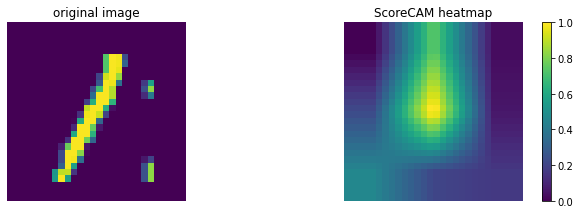

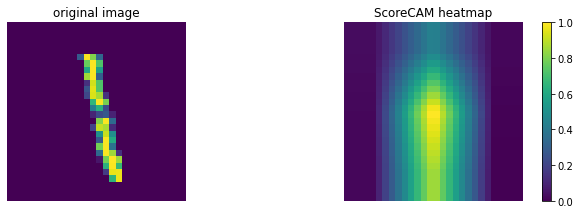

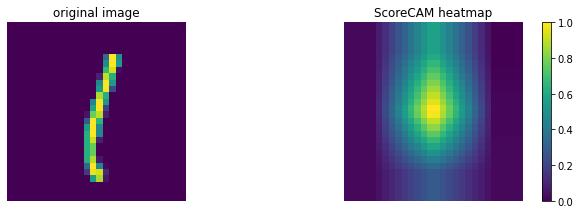

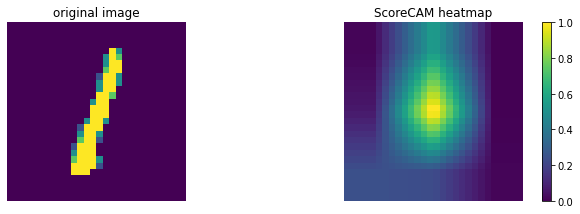

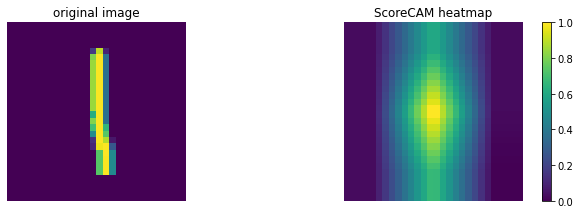

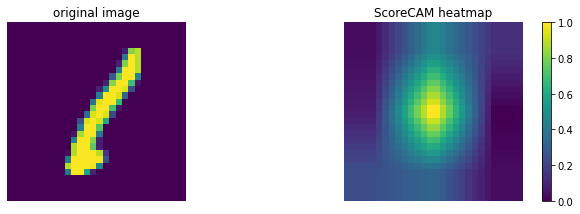

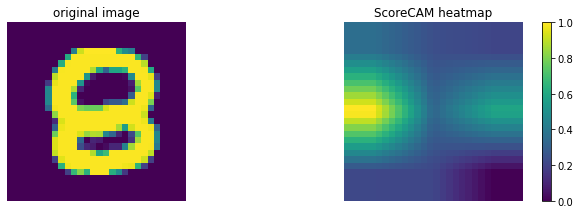

In [12]:
for i in range(20):
    image=next(iter(test_dataloader))[0][0]
    cam, idx = wrapped_model(torch.reshape(image, (1,1,image.shape[0], image.shape[1])))
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
    axs[0].imshow(image)
    axs[0].set_title('original image')
    axs[0].axis('off')

    a=axs[1].imshow(cam.squeeze().numpy())
    axs[1].set_title('ScoreCAM heatmap')
    axs[1].axis('off')

    plt.tight_layout()
    plt.colorbar(a)
    plt.show()

# References
[1] H. Wang, Z. Wang, M. Du, F. Yang, Z. Zhang, S. Ding, P. Mardziel e X. Hu. Score-cam:
Score-weighted visual explanations for convolutional neural networks. In Proceedings of
the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops, pages
24–25, 2020.

[2] J. Adebayo, J. Gilmer, M. Muelly, I. Goodfellow, M. Hardt e B. Kim. Sanity checks for saliency maps. Advances in Neural Information Processing Systems, 2018-Decem(NIPS):
9505–9515, 2018. ISSN 10495258.

[3] R. C. Fong e A. Vedaldi. Interpretable explanations of black boxes by meaningful perturbation. In Proceedings of the IEEE International Conference on Computer Vision, pages
3429–3437, 2017. 

[4] A. Ghorbani, A. Abid e J. Zou. Interpretation of neural networks is fragile. Proceedings
of the AAAI Conference on Artificial Intelligence, 33(01):3681–3688, Jul. 2019. doi: 10.
1609/aaai.v33i01.33013681. URL https://ojs.aaai.org/index.php/AAAI/article/view/4252. 

[5] P.-J. Kindermans, S. Hooker, J. Adebayo, M. Alber, K. T. Schutt, S. D ¨ ahne, D. Erhan e ¨
B. Kim. The (Un)reliability of Saliency Methods, pages 267–280. Springer International 
Publishing, Cham, 2019. ISBN 978-3-030-28954-6. doi: 10.1007/978-3-030-28954-6 URL https://doi.org/10.1007/978-3-030-28954-6_14
